# Naive Risk Budgeting Strategies between PSP and GHP

We've already seen how we can compute the returns of a portfolio that mixes a PSP with a GHP. In this session we'll build some tools to put a more methodical structure around that process.

In [1]:
import numpy as np
import pandas as pd
import edhec_risk_kit as erk
%matplotlib inline
%load_ext autoreload
%autoreload 2

## The Simplest Allocator - Fixed Mix

The allocator's job is to come up with a time series of weights, so let's create the simplest possible allocator - one that puts a fixed fraction in the first portfolio and the remaining in the second


We are now ready to rerun the experiment we ran last time ... a bond portfolio of 60% in the 10 year bond and 40% in the 30 year bond to generate a fixed mix bond portfolio.

In [2]:
rates, zc_prices = erk.cir(10, 500, b=0.03, r_0 = 0.03)
price_10 = erk.bond_price(10, 100, .05, 12, rates)
price_30 = erk.bond_price(30, 100, .05, 12, rates)
rets_30 = erk.bond_total_return(price_30, 100, .05, 12)
rets_10 = erk.bond_total_return(price_10, 100, .05, 12)
rets_bonds = erk.backtest_mix(rets_10, rets_30, allocator=erk.fixedmix_allocator, w1=.6)
mean_rets_bonds = rets_bonds.mean(axis='columns')
erk.summary_stats(pd.DataFrame(mean_rets_bonds))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.036572,0.003246,0.386501,3.320902,-0.001574,-0.001196,1.970273,0.0


Next, we'll use this to create a 70-30 Stock Bond Mix. First, we'll generate stock returns:

In [3]:
price_eq = erk.gbm(n_years=10,n_scenarios=500,mu=0.07, sigma=0.15)
rets_eq = price_eq.pct_change().dropna()
rets_zc = zc_prices.pct_change().dropna()

And next, we'll use the mix backtester to build a 70-30 Stock-Bond mix. One way to assess the performance is, as before, to generate a composite and produce summary stats on the composite. We'll also examine a second approach, which is to compute summary stats on each scenario and average the summary stats.

In [4]:
rets_7030b = erk.backtest_mix(rets_eq, rets_bonds, allocator=erk.fixedmix_allocator, w1=0.7)
rets_7030b_mean = rets_7030b.mean(axis='columns')
erk.summary_stats(pd.DataFrame(rets_7030b_mean))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.062528,0.004584,-0.240865,3.192328,-0.002816,-0.002041,6.905787,0.0


In [5]:
# Approach 2: compute stats on each scenario and then average
summaries = erk.summary_stats(rets_7030b)
summaries.mean()

Annualized Return          0.056977
Annualized Vol             0.107441
Skewness                   0.006094
Kurtosis                   2.958296
Cornish-Fisher VaR (5%)    0.045679
Historic CVaR (5%)         0.057960
Sharpe Ratio               0.244141
Max Drawdown              -0.203196
dtype: float64

However, both of these summaries are imperfect, since they aggregate across a wide distribution. In different situations one or the other might make sense, but for most individuals, the range of outcomes are what matters because we observe only one of the different possible scenarios.

Therefore, it make sense to example the range of possible outcomes and look at not just the average but also the less likely but possible outcomes.

## Distribution of Terminal Values and Measuring Risk Budget Efficiency

The basic idea is to measure the distribution of terminal values across all scenarios.

In [6]:
pd.concat([erk.terminal_stats(rets_bonds, name="Bonds"), 
           erk.terminal_stats(rets_eq, name="Equities"),
           erk.terminal_stats(rets_7030b, name="70/30")],
          axis=1)

,Bonds,Equities,70/30
mean,1.393610,2.016453,1.819262
std,0.102047,0.952560,0.587814
p_breach,NaN,0.038000,0.002000
e_short,NaN,0.077944,0.004381
p_reach,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN


C:\Users\campo\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\campo\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\campo\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

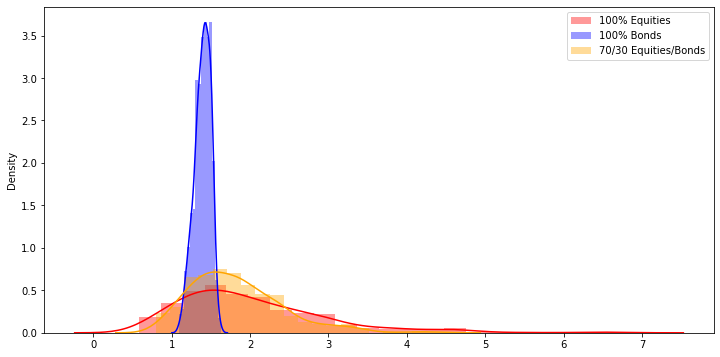

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
sns.distplot(erk.terminal_values(rets_eq), color="red", label="100% Equities")
sns.distplot(erk.terminal_values(rets_bonds), color="blue", label="100% Bonds")
sns.distplot(erk.terminal_values(rets_7030b), color="orange", label="70/30 Equities/Bonds")
plt.legend();

Note how the higher mean return of the equities portfolio is due in part to the large upside spread in equities.

## Risk Budgeting through Glide Path Allocation

A potential improvement over naive fixed mix is to risk budget by making a simplistic assumption that risk = time.

In other words, if you have more time, increase the risk budget. If you have less time, derisk. This is the thinking behind a Target Date Fund.

Let's write an allocator that defines the weights as a glidepath sthat starts at a starting weight and then gradually decreases the weights to equities over time to an ending weight. For example, you can start at 80% stocks at the start of the 10 year period and then gradually move to 20% stocks by the end of the 10 year period.

In [8]:

rets_g8020 = erk.backtest_mix(rets_eq, rets_bonds, allocator=erk.glidepath_allocator, start_glide=.8, end_glide=.2)
pd.concat([erk.terminal_stats(rets_bonds, name="FI"), 
           erk.terminal_stats(rets_eq, name="Eq"),
           erk.terminal_stats(rets_7030b, name="70/30"),
           erk.terminal_stats(rets_g8020, name="Glide 80 to 20")],
          axis=1)

,FI,Eq,70/30,Glide 80 to 20
mean,1.393610,2.016453,1.819262,1.687092
std,0.102047,0.952560,0.587814,0.410888
p_breach,NaN,0.038000,0.002000,NaN
e_short,NaN,0.077944,0.004381,NaN
p_reach,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN


C:\Users\campo\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\campo\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


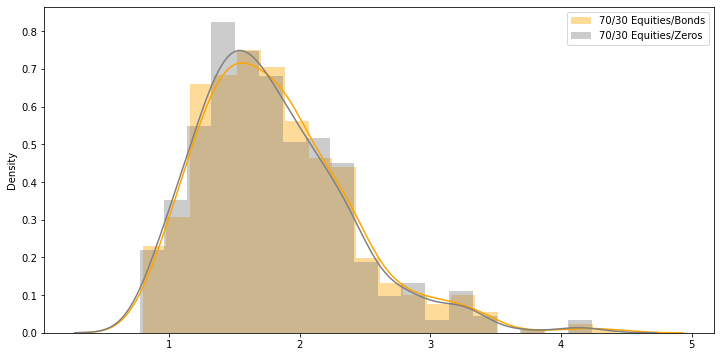

In [9]:
rets_7030z = erk.backtest_mix(rets_eq, rets_zc, allocator=erk.fixedmix_allocator, w1=0.7)
plt.figure(figsize=(12, 6))
#sns.distplot(terminal_values(rets_eq), color="red", label="100% Equities")
#sns.distplot(terminal_values(rets_bonds), color="blue", label="100% Bonds")
sns.distplot(erk.terminal_values(rets_7030b), color="orange", label="70/30 Equities/Bonds")
#sns.distplot(terminal_values(rets_g8020), color="green", label="Glide 80 to 20")
sns.distplot(erk.terminal_values(rets_7030z), color="grey", label="70/30 Equities/Zeros")
plt.legend();

### Conclusion

Static or Naive risk budgeting involves allocating between the PSP and GHP using either a simple fixed mix or a blind glidepath. These can reduce the downside risk but come at the cost the expected return, and cannot be used to secure a minimum acceptable level of wealth or liabilities. In the next session, we'll examine dynamic approaches that will address the challenge of meeting a set of future liabilities such as replacement income, or a required level of wealth in the future.